In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from pandas.api.types import union_categoricals
import gc, os, sys, re, time
#import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from IPython.display import display, Image, HTML

In [2]:
import tensorflow as tf 
import numpy as np 
import math
import os 
from PIL import Image 
import seaborn as sns 
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing 
from scipy.stats import skew, boxcox
from sklearn.model_selection import train_test_split 

from sklearn.metrics import roc_curve,auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score 

from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from pyod.models.lof import LOF
from pyod.models.cof import COF
from pyod.models.iforest import IForest
from sklearn.cluster import DBSCAN

In [3]:
# Standard library imports
import time 

# Third party library imports
import scipy.io 
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

plt.rcParams.update({'font.size': 12})
from collections import defaultdict 
from sklearn.metrics import (auc, average_precision_score,  roc_auc_score, roc_curve, precision_recall_curve) 

In [4]:
def plot_metrics_curvesm(y_true, y_pred_roc, y_pred_prc, title='',saveloc='', label_extra='',**kwargs):
    """
    Plots roc and precision-recall curves

    Arguments
    =========
    y_true (iterator) : actual labels
    y_pred (iterator) : predicted labels
    title (str) : title for subplots
    **kwargs are for plt.plot()

    """
    x_roc, y_roc, _ = roc_curve(y_true, y_pred_roc)
    y_prc, x_prc, _ = precision_recall_curve(y_true, y_pred_prc)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[0].plot(x_roc, y_roc, color='darkorange', lw=2,
                label='{}ROC curve (area {:.2f})'.format(label_extra, roc_auc_score(y_true, y_pred_roc)),
                            **kwargs)
    axs[1].plot(x_prc, y_prc, color='darkorange', lw=2,
                label='{}PRC curve (area {:.2f})'.format(label_extra, average_precision_score(y_true, y_pred_prc)),
                            **kwargs)
    for ax, labels in zip(axs, (('FPR', 'TPR (recall)'), ('TPR (recall)', 'precision'))):
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel(labels[0])
        ax.set_ylabel(labels[1])
        ax.legend(loc="lower right")
    plt.suptitle(title + 'N={} (frac_pos={:.2%})'.format(len(y_true), y_true.mean()))
    plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.9))
    plt.savefig(saveloc)
    plt.show()

In [5]:
def downsample_scale_split_df(df_full, y_column='Target', frac_negative=1, frac_positive=1, scaler=RobustScaler,
                        random_state=1, verbose=False):
    """ Returns downsampled X, y DataFrames, with prescribed downsampling of positives and negatives
    The labels (y's) should have values 0, 1 and be located in y_column
    X will additionally be scaled using the passed scaler

    Arguments
    =========
    df_full (pd.DataFrame) : data to be processed
    y_column (str) : name of the column containing the Class
    frac_negative (int): fraction of negatives in returned data
    frac_positive (int): fraction of negatives in returned data
    scaler (sci-kit learn scaler object)

    Returns
    ========
    downsampled and scaled X (DataFrame) and downsampled y (Series)
    """
    df_downsampled = (pd.concat([df_full.loc[df_full[y_column] == 0].sample(frac=frac_negative,
                                                                        random_state=random_state),
                                df_full.loc[df_full[y_column] == 1].sample(frac=frac_positive,
                                                                       random_state=random_state)])
                              .sample(frac=1, random_state=random_state)) # a random shuffle to mix both classes
    X_downsampled = df_downsampled.loc[:, df_full.columns != y_column]
    y_downsampled = df_downsampled.loc[:, y_column]
    if scaler is not None:
        X_downsampled = scaler().fit_transform(X_downsampled) # Scale the data
    if verbose:
        print('Number of points: {}, number of positives: {} ({:.2%})'.format(
            len(y_downsampled), y_downsampled.sum(), y_downsampled.mean()))
    return(X_downsampled, y_downsampled)

In [6]:
def plot_metrics_curves(y_true, y_pred, title='',  **kwargs):
    """
    Plots roc and precision-recall curves
    
    Arguments
    =========
    y_true (iterator) : actual labels
    y_pred (iterator) : predicted labels
    title (str) : title for subplots
    **kwargs are for plt.plot()
    
    """
    x_roc, y_roc, _ = roc_curve(y_true, y_pred)
    y_prc, x_prc, _ = precision_recall_curve(y_true, y_pred)   
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[0].plot(x_roc, y_roc, color='darkorange', lw=2, 
                label='{}ROC curve (area {:.2f})'.format(title, roc_auc_score(y_true, y_pred)),
                            **kwargs)
    axs[1].plot(x_prc, y_prc, color='darkorange', lw=2, 
                label='{}PR curve (area {:.2f})'.format(title, average_precision_score(y_true, y_pred) ),
                            **kwargs)
    for ax, labels in zip(axs, (('FPR', 'TPR'), ('TPR (recall)', 'precision'))):
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel(labels[0])
        ax.set_ylabel(labels[1])
        ax.legend(loc="lower right")
    plt.show()

In [7]:
def plot_metrics_curves(y_true, y_pred, title='', label_extra='',  **kwargs):
    """
    Plots roc and precision-recall curves

    Arguments
    =========
    y_true (iterator) : actual labels
    y_pred (iterator) : predicted labels
    title (str) : title for subplots
    **kwargs are for plt.plot()

    """
    x_roc, y_roc, _ = roc_curve(y_true, y_pred)
    y_prc, x_prc, _ = precision_recall_curve(y_true, y_pred)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[0].plot(x_roc, y_roc, color='darkorange', lw=2,
                label='{}ROC curve (area {:.2f})'.format(label_extra, roc_auc_score(y_true, y_pred)),
                            **kwargs)
    axs[1].plot(x_prc, y_prc, color='darkorange', lw=2,
                label='{}PRC curve (area {:.2f})'.format(label_extra, average_precision_score(y_true, y_pred)),
                            **kwargs)
    for ax, labels in zip(axs, (('FPR', 'TPR (recall)'), ('TPR (recall)', 'precision'))):
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel(labels[0])
        ax.set_ylabel(labels[1])
        ax.legend(loc="lower right")
    plt.suptitle(title + 'N={} (frac_pos={:.2%})'.format(len(y_true), y_true.mean()))
    plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.9))
    plt.show()

In [8]:
def mad(X):
    """ calculates the median over the first axis, of the column-wise normalized 
    absolute deviation (normalized by iqr)
    """
    iqr =  np.quantile(X, 0.75, axis=0) - np.quantile(X, 0.25, axis=0)
    #the IQR may be zero. To avoid inf, fill with the variance
    iqr[np.where(iqr==0)] = np.var(X, axis=0)[np.where(iqr==0)] 
    return np.median(np.abs(X)/(iqr+0.00000001), axis=1)

def generate_auc_ap_tuple(X, y):
    return roc_auc_score(y, mad(X)), average_precision_score(y, mad(X))

In [9]:

BUILD95 = True
BUILD96 = True

import numpy as np, pandas as pd, os, gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'

In [10]:
%%time
# LOAD TRAIN
X_train = pd.read_csv('train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv('train_identity.csv',index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
# LOAD TEST
X_test = pd.read_csv('test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv('test_identity.csv',index_col='TransactionID', dtype=dtypes)
fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}
test_id.rename(columns=fix, inplace=True)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)
# TARGET
y_train = X_train['isFraud'].copy()
#index for fraud samples
fraud_indices=X_train[X_train['isFraud']== 1].index.values 
#index for non fraud samples
nonfraud_indices=X_train[X_train['isFraud']== 0].index.values
del train_id, test_id, X_train['isFraud']; x = gc.collect()
# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (590540, 213) test shape (506691, 213)
CPU times: user 31.4 s, sys: 1.66 s, total: 33.1 s
Wall time: 33 s


In [11]:
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60) 

In [12]:
%%time
# LABEL ENCODE AND MEMORY REDUCE
for i,f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if (np.str(X_train[f].dtype)=='category')|(X_train[f].dtype=='object'): 
        df_comb = pd.concat([X_train[f],X_test[f]],axis=0)
        df_comb,_ = df_comb.factorize(sort=True)
        if df_comb.max()>32000: print(f,'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt','TransactionDT']:
        mn = np.min((X_train[f].min(),X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1,inplace=True)
        X_test[f].fillna(-1,inplace=True)

CPU times: user 2.89 s, sys: 28.2 ms, total: 2.92 s
Wall time: 2.69 s


In [13]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')
        
# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')
        
# GROUP AGGREGATION MEAN AND STD
# https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')
    
# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

In [14]:
%%time
# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')
# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
# FREQUENCY ENOCDE
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])
# GROUP AGGREGATE
encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

cents, addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1 , card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 'D9_card1_addr1_P_emaildomain_mean' , 'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , CPU times: user 19.2 s, sys: 7.96 s, total: 27.1 s
Wall time: 27 s


In [15]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)
    
# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [16]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 216 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

In [17]:
import datetime
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month 

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month 

In [18]:
X_train['oof'] = 0

In [19]:
X_train['day'] = X_train.TransactionDT / (24*60*60)
X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+np.floor(X_train.day-X_train.D1).astype(str)

X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.day-X_test.D1).astype(str)

In [20]:
%%time
# FREQUENCY ENCODE UID
encode_FE(X_train,X_test,['uid'])
# AGGREGATE 
encode_AG(['TransactionAmt','D4','D9','D10','D15'],['uid'],['mean','std'],fillna=True,usena=True)
# AGGREGATE
encode_AG(['C'+str(x) for x in range(1,15) if x!=3],['uid'],['mean'],X_train,X_test,fillna=True,usena=True)
# AGGREGATE
encode_AG(['M'+str(x) for x in range(1,10)],['uid'],['mean'],fillna=True,usena=True)
# AGGREGATE
encode_AG2(['P_emaildomain','dist1','DT_M','id_02','cents'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREGATE
encode_AG(['C14'],['uid'],['std'],X_train,X_test,fillna=True,usena=True)
# AGGREGATE 
encode_AG2(['C13','V314'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREATE 
encode_AG2(['V127','V136','V309','V307','V320'], ['uid'], train_df=X_train, test_df=X_test)
# NEW FEATURE
X_train['outsider15'] = (np.abs(X_train.D1-X_train.D15)>3).astype('int8')
X_test['outsider15'] = (np.abs(X_test.D1-X_test.D15)>3).astype('int8')
print('outsider15')

uid_FE , 'TransactionAmt_uid_mean' , 'TransactionAmt_uid_std' , 'D4_uid_mean' , 'D4_uid_std' , 'D9_uid_mean' , 'D9_uid_std' , 'D10_uid_mean' , 'D10_uid_std' , 'D15_uid_mean' , 'D15_uid_std' , 'C1_uid_mean' , 'C2_uid_mean' , 'C4_uid_mean' , 'C5_uid_mean' , 'C6_uid_mean' , 'C7_uid_mean' , 'C8_uid_mean' , 'C9_uid_mean' , 'C10_uid_mean' , 'C11_uid_mean' , 'C12_uid_mean' , 'C13_uid_mean' , 'C14_uid_mean' , 'M1_uid_mean' , 'M2_uid_mean' , 'M3_uid_mean' , 'M4_uid_mean' , 'M5_uid_mean' , 'M6_uid_mean' , 'M7_uid_mean' , 'M8_uid_mean' , 'M9_uid_mean' , uid_P_emaildomain_ct, uid_dist1_ct, uid_DT_M_ct, uid_id_02_ct, uid_cents_ct, 'C14_uid_std' , uid_C13_ct, uid_V314_ct, uid_V127_ct, uid_V136_ct, uid_V309_ct, uid_V307_ct, uid_V320_ct, outsider15
CPU times: user 3min 17s, sys: 25 s, total: 3min 42s
Wall time: 3min 41s


In [21]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)
for c in ['oof','DT_M','day','uid']:
    cols.remove(c)
    
# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [22]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 263 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

In [23]:
X_train = X_train[cols]
X_test = X_test[cols]

In [24]:
X_train.head()

,TransactionAmt,ProductCD,card1,card2,card3,card5,card6,addr1,addr2,dist1,...,uid_cents_ct,C14_uid_std,uid_C13_ct,uid_V314_ct,uid_V127_ct,uid_V136_ct,uid_V309_ct,uid_V307_ct,uid_V320_ct,outsider15
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000.0,68.5,4,12926.0,-1.0,50.0,42.0,1,215.0,77.0,19.0,...,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2987001.0,29.0,4,1755.0,304.0,50.0,2.0,1,225.0,77.0,-1.0,...,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2987002.0,59.0,4,3663.0,390.0,50.0,66.0,2,230.0,77.0,287.0,...,1.0,0.0,4.0,1.0,2.0,1.0,1.0,2.0,1.0,1
2987003.0,50.0,4,17132.0,467.0,50.0,17.0,2,376.0,77.0,-1.0,...,1.0,0.0,23.0,1.0,82.0,10.0,9.0,81.0,10.0,1
2987004.0,50.0,1,3497.0,414.0,50.0,2.0,1,320.0,77.0,-1.0,...,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0


In [25]:
print(X_train)

               TransactionAmt  ProductCD    card1  card2  card3  card5  card6  \
TransactionID                                                                   
2987000.0           68.500000          4  12926.0   -1.0   50.0   42.0      1   
2987001.0           29.000000          4   1755.0  304.0   50.0    2.0      1   
2987002.0           59.000000          4   3663.0  390.0   50.0   66.0      2   
2987003.0           50.000000          4  17132.0  467.0   50.0   17.0      2   
2987004.0           50.000000          1   3497.0  414.0   50.0    2.0      1   
...                       ...        ...      ...    ...    ...    ...    ...   
3577535.0           49.000000          4   5550.0   -1.0   50.0  126.0      2   
3577536.0           39.500000          4   9444.0  125.0   50.0  124.0      2   
3577537.0           30.950001          4  11037.0  495.0   50.0  124.0      2   
3577538.0          117.000000          4   6826.0  381.0   50.0  124.0      2   
3577539.0          279.95001

In [26]:
# X_train.to_csv('X_train.csv')
# X_test.to_csv('X_test.csv')
# y_train.to_csv('y_train.csv')

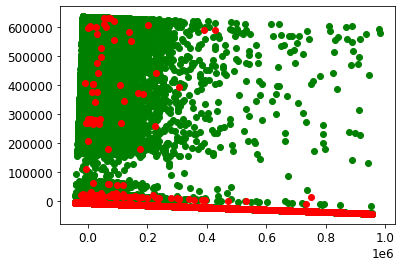

In [27]:
pca=PCA(n_components=2)
X2D = pca.fit_transform(X_train)
indx0=(y_train==0)
plt.scatter(X2D[indx0,0], X2D[indx0,1],c='green')
indx1=(y_train==1)
plt.scatter(X2D[indx1,0], X2D[indx1,1],c='red')

In [28]:
X_test.head()

,TransactionAmt,ProductCD,card1,card2,card3,card5,card6,addr1,addr2,dist1,...,uid_cents_ct,C14_uid_std,uid_C13_ct,uid_V314_ct,uid_V127_ct,uid_V136_ct,uid_V309_ct,uid_V307_ct,uid_V320_ct,outsider15
TransactionID,,,,,,,,,,,,,,,,,,,,,
3663549.0,31.950001,4,9409.0,11.0,50.0,126.0,2,70.0,77.0,1.0,...,5.0,1.938461,31.0,1.0,45.0,3.0,1.0,45.0,3.0,1
3663550.0,49.000000,4,3272.0,11.0,50.0,126.0,2,199.0,77.0,4.0,...,2.0,0.443440,31.0,2.0,28.0,1.0,1.0,28.0,1.0,1
3663551.0,171.000000,4,3476.0,474.0,50.0,126.0,2,372.0,77.0,2635.0,...,1.0,0.315302,14.0,4.0,17.0,3.0,4.0,18.0,2.0,1
3663552.0,284.950012,4,9989.0,260.0,50.0,66.0,2,105.0,77.0,17.0,...,2.0,0.000000,4.0,2.0,2.0,1.0,1.0,2.0,1.0,1
3663553.0,67.949997,4,17018.0,352.0,50.0,17.0,2,164.0,77.0,6.0,...,2.0,1.897367,11.0,4.0,8.0,1.0,4.0,8.0,1.0,1


In [29]:
print(len(np.array(y_train)))

590540


In [30]:
from sklearn.model_selection import KFold
def Split_Set_10_Fold(total_fold,data):
    train_index=[]
    test_index=[]
    np.random.seed(0)
    kf=KFold(n_splits=total_fold,shuffle=True, random_state=True)
    for train_i, test_i in kf.split(data):
        train_index.append(train_i)
        test_index.append(test_i)
    return train_index,test_index
train_fraudindex,test_fraudindex=Split_Set_10_Fold(20,fraud_indices)
train_nonfraudindex,test_nonfraudindex=Split_Set_10_Fold(20,nonfraud_indices)

In [39]:
trainData_sets=[]
trainy_sets=[]
testData_sets=[]
testy_sets=[]
for i in range(1):
    train_indices=np.concatenate([train_fraudindex[i],train_nonfraudindex[i]])
    test_indices=np.concatenate([test_fraudindex[i],test_nonfraudindex[i]])
    trainData_sets.append(X_train.iloc[train_indices,:])
    trainy_sets.append(y_train.iloc[train_indices])
    testData_sets.append(X_train.iloc[test_indices,:])
    testy_sets.append(y_train.iloc[test_indices])


In [40]:
print("ratio of fraud samples:", len(fraud_indices)/(len(nonfraud_indices)+len(fraud_indices)))
print("samples number:",len(nonfraud_indices)+len(fraud_indices))

ratio of fraud samples: 0.03499000914417313
samples number: 590540


# Logistic Regression

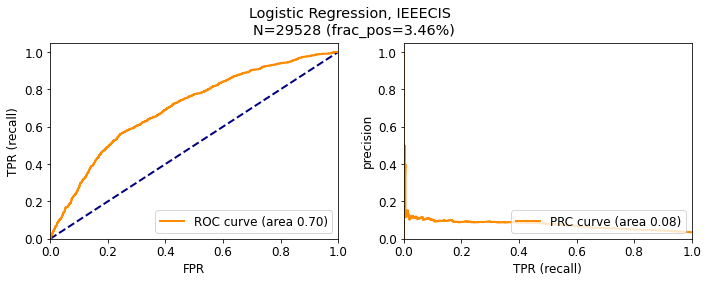

In [36]:
lr_model=LogisticRegression()
lr_model.fit(trainData_sets[0],trainy_sets[0]) 
y_pred_score=lr_model.predict_proba(testData_sets[0])
y_pred_roc=y_pred_score[:,1]
y_pred_prc=y_pred_score[:,1]
plot_metrics_curvesm(testy_sets[0], y_pred_roc, y_pred_prc, title='Logistic Regression, IEEECIS  \n',saveloc='LRIEEECIS.jpg')

# Median Absolute Deviation from the Median (MAD)

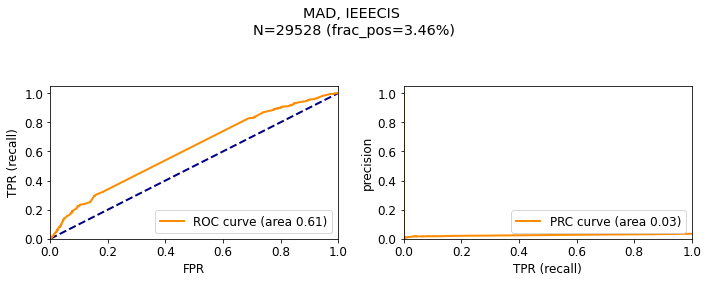

In [38]:
X_downsampled = np.array(testData_sets[0])  
y_pred_roc=mad(X_downsampled)
y_pred_prc=mad(X_downsampled) 
plot_metrics_curvesm(testy_sets[0], -y_pred_roc, y_pred_prc, title='MAD, IEEECIS \n',saveloc='MADIEEECIS.jpg')

# Gussian Mixture Model (for outlier detection)

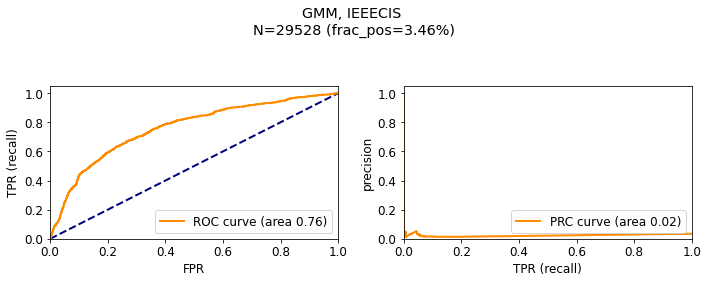

In [39]:
gm=GaussianMixture(n_components=21,random_state=4, reg_covar=1e-2) 
gm.fit(testData_sets[0])
y_pred_roc=gm.score_samples(testData_sets[0]) 

gm=GaussianMixture(n_components=50,random_state=4, reg_covar=1e-2) 
gm.fit(testData_sets[0])
y_pred_prc=gm.score_samples(testData_sets[0])
 
plot_metrics_curvesm(testy_sets[0], -y_pred_roc, y_pred_prc, title='GMM, IEEECIS \n',saveloc='GMMIEEECIS.jpg')

# Local Outlier Factor (LOF)

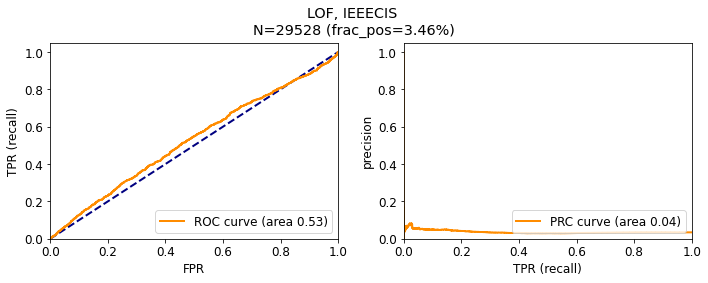

In [28]:
lofm = LOF(n_neighbors = int(4)) 
lofm.fit(testData_sets[0])
y_pred=lofm.predict(testData_sets[0])
y_pred_roc=lofm.decision_function(testData_sets[0])

lofm = LOF(n_neighbors = int(30)) 
lofm.fit(testData_sets[0])
y_pred=lofm.predict(testData_sets[0])
y_pred_prc=lofm.decision_function(testData_sets[0])

 

plot_metrics_curvesm(testy_sets[0], -y_pred_roc, y_pred_prc, title='LOF, IEEECIS \n',saveloc='LOFIEEECIS.jpg')

# Isolation Forest (iForest)

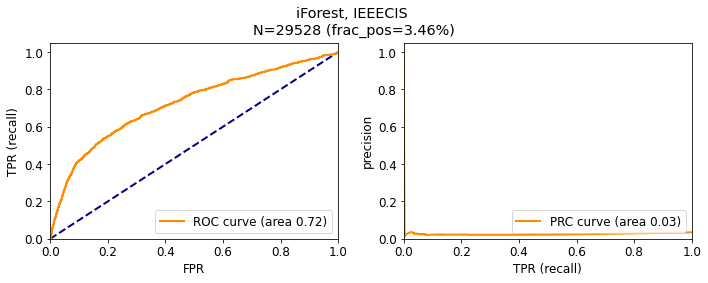

In [29]:
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(n_estimators=int(25), max_samples='auto', contamination=0.05, max_features=4,bootstrap=False, n_jobs=-1, random_state=1)
iforest.fit(testData_sets[0])
y_pred=iforest.predict(testData_sets[0])
y_pred_roc=iforest.decision_function(testData_sets[0]) 


iforest = IsolationForest(n_estimators=int(5), max_samples='auto', contamination=0.05, max_features=4,bootstrap=False, n_jobs=-1, random_state=1)
iforest.fit(testData_sets[0])
y_pred=iforest.predict(testData_sets[0])
y_pred_prc=iforest.decision_function(testData_sets[0]) 
 

plot_metrics_curvesm(testy_sets[0], -y_pred_roc,y_pred_prc, title='iForest, IEEECIS \n',saveloc='iForestIEEECIS.jpg')

# DBSCAN

In [42]:
def downsample_scale_split_df(df_full, y_column='Class', frac_negative=1, frac_positive=1, scaler=RobustScaler,
                        random_state=1, verbose=False):
    """ Returns downsampled X, y DataFrames, with prescribed downsampling of positives and negatives
    The labels (y's) should have values 0, 1 and be located in y_column
    X will additionally be scaled using the passed scaler

    Arguments
    =========
    df_full (pd.DataFrame) : data to be processed
    y_column (str) : name of the column containing the Class
    frac_negative (int): fraction of negatives in returned data
    frac_positive (int): fraction of negatives in returned data
    scaler (sci-kit learn scaler object)

    Returns
    ========
    downsampled and scaled X (DataFrame) and downsampled y (Series)
    """
    df_downsampled = (pd.concat([df_full.loc[df_full[y_column] == 0].sample(frac=frac_negative,
                                                                        random_state=random_state),
                                df_full.loc[df_full[y_column] == 1].sample(frac=frac_positive,
                                                                       random_state=random_state)])
                              .sample(frac=1, random_state=random_state)) # a random shuffle to mix both classes
    X_downsampled = df_downsampled.loc[:, df_full.columns != y_column]
    y_downsampled = df_downsampled.loc[:, y_column]
    if scaler is not None:
        X_downsampled = scaler().fit_transform(X_downsampled) # Scale the data
    if verbose:
        print('Number of points: {}, number of positives: {} ({:.2%})'.format(
            len(y_downsampled), y_downsampled.sum(), y_downsampled.mean()))
    return(X_downsampled, y_downsampled)

In [43]:
# Run this for various min_samples and epsilon
def dbscan_scan(X, y, min_samples_list=(5, 10), epsilon_list=(1, 2, 5, 10), random_state=None):
    """ A scan function for DBSCAN. Iterates over min_samples_list and epsilon_list
    random_state (None or int) : if int, this will be set as a random seed and data will be shuffled
    """
    dbscan_dict = defaultdict(list)
    if random_state:
        np.random.seed(random_state)
        idx = np.random.choice(len(y), len(y), replace=False)
        X = X[idx, :]
        y = y[idx]

    for min_samples in min_samples_list:
        for epsilon in epsilon_list:            
            print('calculating result for epsilon {}, min_samples {}...'.format(
            epsilon, min_samples))
            
            # dbscan_outlier_pred returns 1 for the outlier class, and 0 for the main "inlier" class
            y_predicted = dbscan_outlier_pred(X, epsilon=epsilon, min_samples=min_samples) 
            auc_db = roc_auc_score(y_true=y, y_score=y_predicted)
            pr_db = average_precision_score(y_true=y, y_score=y_predicted)
            num_clusters = len(set(y_predicted))
            precision_outlier_class = y[y_predicted == 1].mean()
            size_outlier_cluster = np.sum(y_predicted == 1)

            # store results in a DataFrame
            
            for k, v in (('epsilon', epsilon), ('min_samples', min_samples), ('AUC', auc_db), 
                         ('num_clusters', num_clusters), ('size_outlier_cluster', size_outlier_cluster), 
                         ('AP', pr_db), ('precision_outlier_class', precision_outlier_class),
                         ('random_state', random_state)):
                dbscan_dict[k].append(v)
        dbscan_results_df = pd.DataFrame.from_dict(dbscan_dict)

    return dbscan_results_df

In [44]:
def dbscan_outlier_pred(X, epsilon=0.3, min_samples=10, **kwargs):
    db = DBSCAN(eps=epsilon, min_samples=min_samples, **kwargs)
    db.fit(X)
    return labels_from_DBclusters(db)

In [45]:
def labels_from_DBclusters(db):
    """
    Returns labels for each point for "outlierness", based on DBSCAN results.
    The higher the score, the more likely the point is an outlier, based on its cluster membership
    
    - dbscan label -1 (outliers): highest score of 1
    - largest cluster gets score 0  
    - points belonging to clusters get a score that is higher when the cluster size is smaller
    
    db: a fitted DBscan instance
    Returns: labels (similar to "y_predicted", but the values merely reflect a ranking)
    """
    labels = np.zeros(len(db.labels_))
    
    # make a list of tuples: (i, num points in i) for i in db.labels_
    label_counts = [(i, np.sum(db.labels_==i)) for i in set(db.labels_) - set([-1])]
    label_counts.sort(key=lambda x : -x[1]) # sort by counts per class, descending
    
    # assign the labels. Those points with label =-1 get highest label (equal to number of classes -1) 
    labels[db.labels_== -1] = len(set(db.labels_)) - 1
    for i, (label, label_count) in enumerate(label_counts):
        labels[db.labels_==label] = i
        
    # Scale the values between 0 and 1
    labels = (labels - min(labels)) / (max(labels) - min(labels)+0.00000001)
    return(labels) 

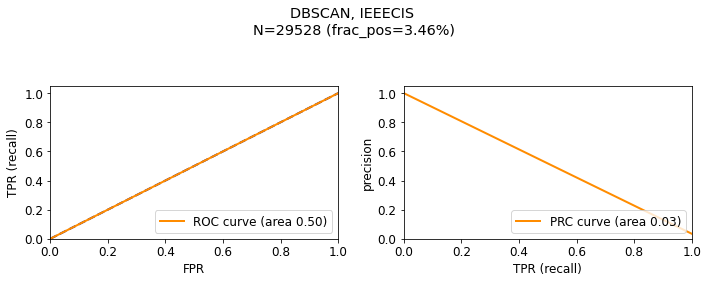

In [46]:
X_downsampled = testData_sets[0] #RobustScaler().fit_transform(X_test)
y_pred_roc = dbscan_outlier_pred(X_downsampled, min_samples=20, epsilon=50.0) 

X_downsampled = testData_sets[0] #RobustScaler().fit_transform(X_test)
y_pred_prc = dbscan_outlier_pred(X_downsampled, min_samples=10, epsilon=50.0) 

 

plot_metrics_curvesm(testy_sets[0], y_pred_roc,y_pred_prc, title='DBSCAN, IEEECIS \n',saveloc='DBSCANIEEECIS.jpg')

# Principal Component Analysis (PCA)

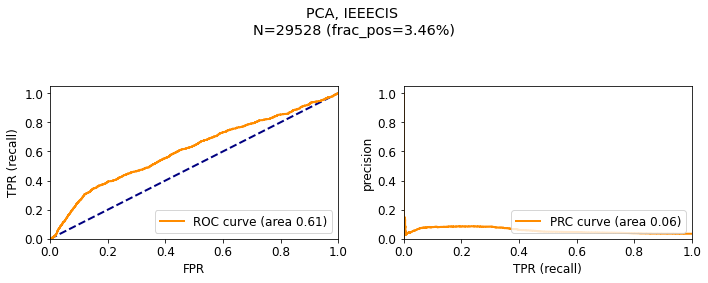

In [33]:
pca = PCA()
pca.fit(testData_sets[0])
transformed_data = pca.transform(testData_sets[0])
Data = transformed_data 
lambdas = pca.singular_values_
M = ((Data*Data)/lambdas)  
y_pred_roc=np.sum(M,axis=1)  

pca = PCA()
pca.fit(testData_sets[0])
transformed_data = pca.transform(testData_sets[0])
Data = transformed_data 
lambdas = pca.singular_values_
M = ((Data*Data)/lambdas)  
y_pred_prc=np.sum(M,axis=1) 

 
plot_metrics_curvesm(testy_sets[0], y_pred_roc,y_pred_prc, title='PCA, IEEECIS \n',saveloc='PCAIEEECIS.jpg')

# OP Model_L1

In [68]:
 #OP Model with L1 norm
from tensorflow.python.ops.linalg_ops import norm_v2
class OP_main():
    
    def __init__(self,Data, lam,th=0.000000000000001, rho=1.5, mup=1.25): 


        n1,n2=np.shape(Data)
        self.lam=lam #1/np.sqrt(n1)
        self.eps=0.000000000000001
        self.d_nrom=norm_v2(Data)
        norm_two=np.linalg.svd(Data,compute_uv=False)[0]#norm_v2(Data,2) 
        norm_inf=norm_v2(Data,np.inf)/self.lam 
        dual_norm=np.max([norm_two, norm_inf])
        Lambda_int=Data/dual_norm 
        self.mu=mup/norm_two #1.25
        self.maxmu=self.mu*10**(7)
        self.rho=rho #1.5
        self.stages=200 
        self.tol=10**(-7) 
        
        
        X_int, E_int= tf.zeros([n1,n2], tf.float32), tf.zeros([n1,n2], tf.float32)
        value_sets=(Data, X_int, E_int, Lambda_int)
        self.FX, self.FE = self.OP_ADMM_main(value_sets) 
        self.Elabel=self.getLable(self.FE,th)
 
    def OP_ADMM_main(self, inputs):
        (Data, X_int, E_int, Lambda_int) = inputs  
        self.X,self.E,self.Lambda  = [],[],[]  
        self.E.append(self.Updata_E(Data, X_int, Lambda_int))  
        self.X.append(self.Updata_X(Data, self.E[-1], Lambda_int))      
        self.Lambda.append(self.Updata_Lambda(Data, self.X[-1], self.E[-1], Lambda_int))  
        self.mu=np.min([self.mu*self.rho, self.maxmu]) 
        for stage in range(1,self.stages): 
            self.E.append(self.Updata_E(Data, self.X[-1], self.Lambda[-1]))  
            self.X.append(self.Updata_X(Data, self.E[-1], self.Lambda[-1]))      
            self.Lambda.append(self.Updata_Lambda(Data, self.X[-1], self.E[-1], self.Lambda[-1]))   
            self.mu=np.min([self.mu*self.rho, self.maxmu]) 
            stopCriterion= norm_v2(Data-self.X[-1]-self.E[-1])/self.d_nrom   
            if stopCriterion < self.tol:
                break 
        print("Stop Criterion: {}".format(stopCriterion))
        return self.X[-1], self.E[-1]   
     

     

    def Updata_X(self,Data, E, Lambda):
        
        temp=-E+Data+Lambda/self.mu  
        return self.SVT(temp,1/self.mu)

 
   
    def SVT(self,X,th):
        n1, n2= np.shape(X)
        rank=np.min([n1,n2])  
        U_int, S_int, VT_int=np.linalg.svd(X, full_matrices=True, compute_uv=True, hermitian=False)
        S_int=tf.nn.relu(S_int-tf.multiply(th,tf.ones(np.shape(S_int), tf.float32)))
        rank=len(np.where(S_int > self.eps)[0])
        if rank==0:
            rank=1  
        S_int=tf.compat.v1.matrix_diag(S_int) 
        Ak_int=tf.matmul(tf.matmul(U_int[:,0:rank],S_int[0:rank,0:rank]),VT_int[0:rank,:]) 
          
        return Ak_int    
 
    def Updata_E(self, Data, X, Lambda):
      
        Temp= Data-X+Lambda/self.mu
        return self.sparse_col(  Temp, self.lam/self.mu)
 

   

    def sparse_col(self, E, tau): 
        result=[]
        n1,n2=np.shape(E)
        for i in range(n2):
            result.append(tf.nn.relu(tf.norm(E[:,i])-tau)*E[:,i]/(tf.norm(E[:,i])+self.eps)) 
        return tf.transpose(result,[1,0])

  
     

    def Updata_Lambda(self, Data, X, E, Lambda):
        Lambda= Lambda+tf.multiply(self.mu, Data-X-E)
        return Lambda
 

    def getLable(self, E,th): 
        Elabel=[]
        n1,n2=np.shape(E)
        for i in range(n2):
            if tf.norm(E[:,i])>th:
                Elabel.append(0)
            else:
                Elabel.append(1)
        return Elabel
         
    def getLable2(self, E,num=300): 
        Elabel=[]
        Enum=[]
        n1,n2=np.shape(E)
        for i in range(n2):
            Enum.append(tf.norm(E[:,i]))
        ind = np.argpartition(Enum, -num)[-num:]
        for i in range(n2):
            if i in ind:
                Elabel.append(1)
            else:
                Elabel.append(0)
        return Elabel
    
def getEnorm(E):
    Enum=[]
    n1,n2=np.shape(E)
    for i in range(n2):
        Enum.append(tf.norm(E[:,i])) 
    return  Enum
def normlize(Data):
    newData=[]
    n1,n2=np.shape(Data)
    for i in range(n2):
        newData.append(Data[:,i]/tf.norm(Data[:,i])) 
    return  tf.transpose(newData,[1,0])
def getMax(E):
    Enum=[]
    n1,n2=np.shape(E)
    for i in range(n2):
        Enum.append(np.max(E[:,i])) 
    return  Enum

Stop Criterion: 7.608448981955007e-08
Stop Criterion: 8.659328187832216e-08


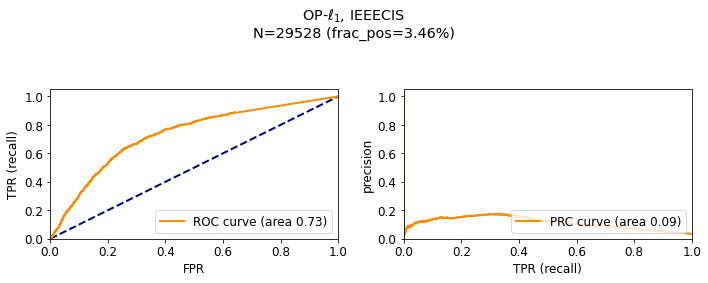

In [ ]:
Data0=tf.transpose(np.array(testData_sets[0]),[1,0])
Data0=tf.cast(Data0,tf.float32)


H=OP_main(Data0, 0.09)  
y_score=getEnorm(H.FE)
y_pred_roc= y_score/np.max(y_score)

H=OP_main(Data0, 0.15)  
y_score=getEnorm(H.FE)
y_pred_prc= y_score/np.max(y_score)
     
plot_metrics_curvesm(testy_sets[0], y_pred_roc,y_pred_prc, title='OP-$\ell_1$, IEEECIS \n',saveloc='OPL1IEEECIS.jpg')

## Outlier Pursuit Model with Lp norm

In [34]:
#OP model with GST
from tensorflow.python.ops.linalg_ops import norm_v2
class OPGST_main():
    
    def __init__(self, Data, lam,p=1, th=0.000000000000001, rho=1.5, mup=1.25):
        
        #(Data, lam,th, rho, mup)=value_sets

        self.p=p
        n1,n2=np.shape(Data)
        self.lam=lam #1/np.sqrt(n1)
        self.eps=0.000000000000001
        self.d_nrom=norm_v2(Data)
        norm_two=np.linalg.svd(Data,compute_uv=False)[0]#norm_v2(Data,2) 
        norm_inf=norm_v2(Data,np.inf)/self.lam 
        dual_norm=np.max([norm_two, norm_inf])
        Lambda_int=Data/dual_norm 
        self.mu=mup/norm_two #1.25
        self.maxmu=self.mu*10**(7)
        self.rho=rho #1.5
        self.stages=200 
        self.tol=10**(-7) 
        
        X_int, E_int= tf.zeros([n1,n2], tf.float32), tf.zeros([n1,n2], tf.float32)
        value_sets=(Data, X_int, E_int, Lambda_int)
        self.FX, self.FE = self.OP_ADMM_main(value_sets) 
        self.Elabel=self.getLable(self.FE,th)
 
    def OP_ADMM_main(self, inputs):
        (Data, X_int, E_int, Lambda_int) = inputs  
        self.X,self.E,self.Lambda  = [],[],[]  
        self.E.append(self.Updata_E(Data, X_int, Lambda_int))  
        self.X.append(self.Updata_X(Data, self.E[-1], Lambda_int))      
        self.Lambda.append(self.Updata_Lambda(Data, self.X[-1], self.E[-1], Lambda_int))  
        self.mu=np.min([self.mu*self.rho, self.maxmu])  
        for stage in range(1,self.stages): 
            self.E.append(self.Updata_E(Data, self.X[-1], self.Lambda[-1]))  
            self.X.append(self.Updata_X(Data, self.E[-1], self.Lambda[-1]))      
            self.Lambda.append(self.Updata_Lambda(Data, self.X[-1], self.E[-1], self.Lambda[-1]))   
            self.mu=np.min([self.mu*self.rho, self.maxmu]) 
            stopCriterion= norm_v2(Data-self.X[-1]-self.E[-1])/self.d_nrom  
            if stopCriterion < self.tol:
                break 
        print("Stop Criterion: {}".format(stopCriterion))
        return self.X[-1], self.E[-1]   
     

     

    def Updata_X(self,Data, E, Lambda):#需要修改
      
        temp=-E+Data+Lambda/self.mu  
        return self.SVT(temp,1/self.mu)

 
   
    def SVT(self,X,th):
        n1, n2= np.shape(X)
        rank=np.min([n1,n2])  
        U_int, S_int, VT_int=np.linalg.svd(X, full_matrices=True, compute_uv=True, hermitian=False)
        S_int=self.Generalized_Soft_Thresholding(S_int,th,self.p)
        rank=len(np.where(S_int > self.eps)[0])
        if rank==0:
            rank=1  
        S_int=tf.compat.v1.matrix_diag(S_int) 
        Ak_int=tf.matmul(tf.matmul(U_int[:,0:rank],S_int[0:rank,0:rank]),VT_int[0:rank,:]) 
          
        return Ak_int    
 
    def Updata_E(self, Data, X, Lambda):
        
        Temp= Data-X+Lambda/self.mu
        return self.sparse_col(  Temp, self.lam/self.mu)
 

   

    def sparse_col(self, E, tau): 
        result=[]
        n1,n2=np.shape(E)
        for i in range(n2):
            result.append(self.Generalized_Soft_Thresholding(tf.norm(E[:,i]),tau,self.p)*E[:,i]/(tf.norm(E[:,i])+self.eps)) 
        return tf.transpose(result,[1,0])

  
     

    def Updata_Lambda(self, Data, X, E, Lambda):
        Lambda= Lambda+tf.multiply(self.mu, Data-X-E)
        return Lambda
 

    def getLable(self, E,th): 
        Elabel=[]
        n1,n2=np.shape(E)
        for i in range(n2):
            if tf.norm(E[:,i])>th:
                Elabel.append(1)
            else:
                Elabel.append(0)
        return Elabel
         
        
    def Generalized_Soft_Thresholding(self,S,weight,p):
        #diagS: a vector
        #weight: a value
        if np.shape(S) == ():
            diagS=[S]
        else:
            diagS=S#np.array(diagS,np.float64)
        J=5 
        sigma0   =    np.abs(diagS)
        tau_GST  =   (2*weight*(1-p))**(1/(2-p))   +   p*weight*(2*(1-p)*weight)**((p-1)/(2-p)) 
        Delta=[];
        for i in range(len(diagS)):
                if sigma0[i]>tau_GST: 
                    delta=sigma0[i]  
                    for k in range(J): 
                            delta=sigma0[i]-weight*p*delta**(p-1)           
                            k=k+1  
                    Delta.append(np.sign(diagS[i])*delta)  
                else:
                    Delta.append(0) 
        if np.shape(S) == ():
            return np.array(Delta[0],np.float32) 
        else:
            return np.array(Delta,np.float32)  

def getEnorm(E):
    Enum=[]
    n1,n2=np.shape(E)
    for i in range(n2):
        Enum.append(tf.norm(E[:,i])) 
    return  Enum
def normlize(Data):
    newData=[]
    n1,n2=np.shape(Data)
    for i in range(n2):
        newData.append(Data[:,i]/tf.norm(Data[:,i])) 
    return  tf.transpose(newData,[1,0])
def getMax(E):
    Enum=[]
    n1,n2=np.shape(E)
    for i in range(n2):
        Enum.append(np.max(E[:,i])) 
    return  Enum

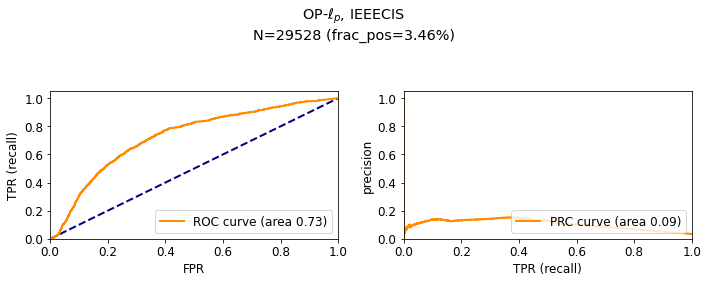

In [36]:
Data0=tf.transpose(np.array(testData_sets[0]),[1,0])
Data0=tf.cast(Data0, tf.float32)
y_test=np.array(testy_sets[0])
del testData_sets,testy_sets

 


HGST=OPGST_main(Data0,0.05,0.9)  
y_score=getEnorm(HGST.FE)
y_pred_roc= y_score/np.max(y_score)

HGST=OPGST_main(Data0,0.09, 0.9)   
y_score=getEnorm(HGST.FE)
y_pred_prc= y_score/np.max(y_score)
     
plot_metrics_curvesm(y_test, y_pred_roc,y_pred_prc, title='OP-$\ell_p$, IEEECIS \n',saveloc='OPLpIEEECIS.jpg')

## Outlier Pursuit Model with ETP

In [37]:
#OP model with ETP
from tensorflow.python.ops.linalg_ops import norm_v2
class OPETP_main():
    
    def __init__(self, Data, lam, p=1, th=0.000000000000001, rho=1.5, mup=1.25,Maxiter=1000,tol=10**(-7)):
        
        #(Data, lam,th, rho, mup)=value_sets

        self.p=p
        n1,n2=np.shape(Data)
        self.lam=lam #1/np.sqrt(n1)
        self.eps=0.000000000000001
        self.d_nrom=norm_v2(Data)
        norm_two=np.linalg.svd(Data,compute_uv=False)[0]#norm_v2(Data,2)
        #print(norm_two)
        norm_inf=norm_v2(Data,np.inf)/self.lam
        #print(norm_inf)
        dual_norm=np.max([norm_two, norm_inf])
        Lambda_int=Data/dual_norm
        #print(Lambda_int[0,0]) 
        self.mu=mup/norm_two #1.25
        self.maxmu=self.mu*10**(7)
        self.rho=rho #1.5
        self.stages=200
        self.tol=10**(-7) 
        
        X_int, E_int= tf.zeros([n1,n2], tf.float32), tf.zeros([n1,n2], tf.float32)
        value_sets=(Data, X_int, E_int, Lambda_int)
        self.FX, self.FE = self.OP_ADMM_main(value_sets) 
        self.Elabel=self.getLable(self.FE,th)
 
    def OP_ADMM_main(self, inputs):
        (Data, X_int, E_int, Lambda_int) = inputs  
        self.X,self.E,self.Lambda  = [],[],[]  
        self.E.append(self.Updata_E(Data, X_int, Lambda_int))  
        self.X.append(self.Updata_X(Data, self.E[-1], Lambda_int))      
        self.Lambda.append(self.Updata_Lambda(Data, self.X[-1], self.E[-1], Lambda_int))  
        self.mu=np.min([self.mu*self.rho, self.maxmu])
        #print(self.E[-1][0,0])
        #print(self.X[-1][0,0])  
        #print(self.Lambda[-1][0,0])  
        for stage in range(1,self.stages): 
            self.E.append(self.Updata_E(Data, self.X[-1], self.Lambda[-1]))  
            self.X.append(self.Updata_X(Data, self.E[-1], self.Lambda[-1]))      
            self.Lambda.append(self.Updata_Lambda(Data, self.X[-1], self.E[-1], self.Lambda[-1]))   
            self.mu=np.min([self.mu*self.rho, self.maxmu]) 
            stopCriterion= norm_v2(Data-self.X[-1]-self.E[-1])/self.d_nrom 
            print("Stop Criterion: {}".format(stopCriterion))
            #print(self.E[-1][0,0])
           # print(self.X[-1][0,0]) 
            #print(self.Lambda[-1][0,0])
            if stopCriterion < self.tol:
                break 
        return self.X[-1], self.E[-1]   
     

     

    def Updata_X(self,Data, E, Lambda): 
      
        temp=-E+Data+Lambda/self.mu  
        return self.SVT(temp,1/self.mu)

 
   
    def SVT(self,X,th):
        n1, n2= np.shape(X)
        rank=np.min([n1,n2])  
        U_int, S_int, VT_int=np.linalg.svd(X, full_matrices=True, compute_uv=True, hermitian=False)
        S_int=self.GAI_ETP(S_int,th,self.p)
        rank=len(np.where(S_int > self.eps)[0])
        if rank==0:
            rank=1  
        S_int=tf.compat.v1.matrix_diag(S_int) 
        Ak_int=tf.matmul(tf.matmul(U_int[:,0:rank],S_int[0:rank,0:rank]),VT_int[0:rank,:]) 
          
        return Ak_int    
 
    def Updata_E(self, Data, X, Lambda): 
        Temp= Data-X+Lambda/self.mu 
        return self.sparse_col(  Temp, self.lam/self.mu)
 

   

    def sparse_col(self, E, tau): 
        result=[]
        n1,n2=np.shape(E)
        for i in range(n2):
            result.append(self.GAI_ETP(tf.norm(E[:,i]),tau,self.p)*E[:,i]/(tf.norm(E[:,i])+self.eps)) 
        return tf.transpose(result,[1,0])

  
     

    def Updata_Lambda(self, Data, X, E, Lambda):
        Lambda= Lambda+tf.multiply(self.mu, Data-X-E)
        return Lambda
 

    def getLable(self, E,th): 
        Elabel=[]
        n1,n2=np.shape(E)
        for i in range(n2):
            if tf.norm(E[:,i])>th:
                Elabel.append(1)
            else:
                Elabel.append(0)
        return Elabel
         
        
   

    def GAI_ETP(self,xi,lambd,gamma,Iter=10,tol=10**(-6)):
        #Iter=10; 
        a0=np.max([np.log((1-np.exp(-gamma))/(lambd*gamma**2))/(-gamma),0])
        #print(a0)
        delta=a0+self.ETP_gradient(a0,gamma,lambd)
        #print(delta) 
        if np.shape(xi) == ():
            x=[xi]
        else:
            x=xi
        n=len(x)
        y=[]
 

     
        for j in range(n):
            gradient_g= self.ETP_gradient(x[j],gamma,lambd)
            if gradient_g==0:
                BARx_b=x[j] 
            else:
                if delta<x[j]:
                    a=x[j]
                    sto=0
                    kkk=0
                    while sto==0:
                        kkk=kkk+1
                        a1=x[j]-self.ETP_gradient(a,gamma,lambd)
                        a2=x[j]-self.ETP_gradient(a1,gamma,lambd) 
                        if np.abs(a2-2*a1+a)<tol or kkk>=Iter:
                            if np.abs(a2-2*a1+a)<self.eps:
                                BARx_b=a2
                            else:
                                BARx_b=a1-(a2-a1)*(a1-a)/(a2-2*a1+a)
                            break
                        a=a1-(a2-a1)*(a1-a)/(a2-2*a1+a) 
                        #print(a)
                else:
                    BARx_b=a0
            if self.ETP_fun(BARx_b,x[j],gamma,lambd)<=self.ETP_fun(0,x[j],gamma,lambd):
                y.append(BARx_b)   
            else:
                y.append(0)
                    
        if np.shape(xi) == ():
            return np.array(y[0],np.float32) 
        else:
            return np.array(y,np.float32)
      
           
    #ETP's gradient 
    def ETP_gradient(self,x,gamma,lambd):
        gradient_g=gamma*lambd*np.exp(-gamma*x)/(1-np.exp(-gamma)) 
        return gradient_g
 
    def ETP_fun(self,x,y,gamma,lambd):
        g=1/2*(y-x)**2+lambd*(1-np.exp(-gamma*x))/(1-np.exp(-gamma))
        return g   

#Data0=tf.transpose(X_test,[1,0])
def getEnorm(E):
    Enum=[]
    n1,n2=np.shape(E)
    for i in range(n2):
        Enum.append(tf.norm(E[:,i])) 
    return  Enum
def normlize(Data):
    newData=[]
    n1,n2=np.shape(Data)
    for i in range(n2):
        newData.append(Data[:,i]/tf.norm(Data[:,i])) 
    return  tf.transpose(newData,[1,0])
def getMax(E):
    Enum=[]
    n1,n2=np.shape(E)
    for i in range(n2):
        Enum.append(np.max(E[:,i])) 
    return  Enum

Stop Criterion: 0.145642951130867
Stop Criterion: 0.12818433344364166
Stop Criterion: 0.10394524782896042
Stop Criterion: 0.05569499358534813
Stop Criterion: 0.033019158989191055
Stop Criterion: 0.022123271599411964
Stop Criterion: 0.01460929773747921
Stop Criterion: 0.011847722344100475
Stop Criterion: 0.01033088006079197
Stop Criterion: 0.008121057413518429
Stop Criterion: 0.006621246226131916
Stop Criterion: 0.005274713505059481
Stop Criterion: 0.0037923555355519056
Stop Criterion: 0.002653185511007905
Stop Criterion: 0.0017418147763237357
Stop Criterion: 0.0011010896414518356
Stop Criterion: 0.0006544109783135355
Stop Criterion: 0.0004145110142417252
Stop Criterion: 0.00026573159266263247
Stop Criterion: 0.00018145516514778137
Stop Criterion: 0.00011396012268960476
Stop Criterion: 7.831581751815975e-05
Stop Criterion: 6.01138781348709e-05
Stop Criterion: 4.609708412317559e-05
Stop Criterion: 3.371978527866304e-05
Stop Criterion: 2.370612128288485e-05
Stop Criterion: 1.6724210581742

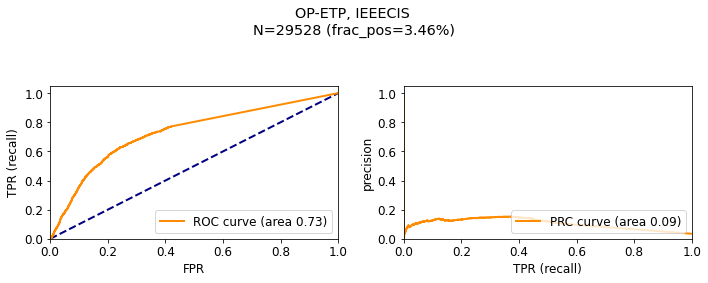

In [41]:
Data0=tf.transpose(np.array(testData_sets[0]),[1,0])
Data0=tf.cast(Data0, tf.float32)
y_test=np.array(testy_sets[0])
del testData_sets,testy_sets

OPETP=OPETP_main(Data0,0.1,0.000001)  
y_score=getEnorm(OPETP.FE)
y_pred_roc= y_score/np.max(y_score)

OPETP=OPETP_main(Data0,0.13, 0.000001)   
y_score=getEnorm(OPETP.FE)
y_pred_prc= y_score/np.max(y_score)
     
plot_metrics_curvesm(y_test, y_pred_roc,y_pred_prc, title='OP-ETP, IEEECIS \n',saveloc='OPETPIEEECIS.jpg')